In [ ]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt 
import plotly.offline as pyo
pyo.init_notebook_mode()
pd.set_option('display.max_columns', None)  # or specify a number, e.g., 100
# Set the width of the display
pd.set_option('display.width', 1000)
con = sqlite3.connect('./Desktop/nba.sqlite')

In [2]:
data =pd.read_sql_query("select game_date,game_id,team_abbreviation_home,fg_pct_home,fg_pct_away,fg3_pct_home,fg3_pct_away,reb_home,reb_away,ast_home,ast_away,tov_home,tov_away,wl_home from Game where game_date between '1946-01-01' and '2003-01-01'",con)

In [3]:
data.isna().sum()

game_date                 0
game_id                   0
team_abbreviation_home    0
fg_pct_home               0
fg_pct_away               0
fg3_pct_home              0
fg3_pct_away              0
reb_home                  0
reb_away                  0
ast_home                  0
ast_away                  0
tov_home                  0
tov_away                  0
wl_home                   0
dtype: int64

In [4]:
data['win'] = data['wl_home'].apply(lambda x: 1 if x == 'W' else 0)
data['fg_pct_diff'] = data['fg_pct_home'] - data['fg_pct_away']
data['fg3_pct_diff'] = data['fg3_pct_home'] - data['fg3_pct_away']
data['reb_diff'] = data['reb_home'] - data['reb_away']
data['ast_diff'] = data['ast_home'] - data['ast_away']
data['tov_diff'] = data['tov_home'] - data['tov_away']
data.head()

,game_date,game_id,team_abbreviation_home,fg_pct_home,fg_pct_away,fg3_pct_home,fg3_pct_away,reb_home,reb_away,ast_home,ast_away,tov_home,tov_away,wl_home,win,fg_pct_diff,fg3_pct_diff,reb_diff,ast_diff,tov_diff
0,1946-11-01 00:00:00,0024600001,HUS,0.467306,0.45489,0.34614,0.336659,43.74704,42.104453,23.931136,22.125058,14.778305,15.19656,L,0,0.012415,0.009481,1.642586,1.806078,-0.418255
1,1946-11-02 00:00:00,0024600003,BOM,0.339000,0.22200,0.34614,0.336659,43.74704,42.104453,23.931136,22.125058,14.778305,15.19656,W,1,0.117000,0.009481,1.642586,1.806078,-0.418255
2,1946-11-02 00:00:00,0024600002,PRO,0.467306,0.45489,0.34614,0.336659,43.74704,42.104453,23.931136,22.125058,14.778305,15.19656,W,1,0.012415,0.009481,1.642586,1.806078,-0.418255
3,1946-11-02 00:00:00,0024600004,CHS,0.467306,0.45489,0.34614,0.336659,43.74704,42.104453,23.931136,22.125058,14.778305,15.19656,W,1,0.012415,0.009481,1.642586,1.806078,-0.418255
4,1946-11-02 00:00:00,0024600005,DEF,0.467306,0.45489,0.34614,0.336659,43.74704,42.104453,23.931136,22.125058,14.778305,15.19656,L,0,0.012415,0.009481,1.642586,1.806078,-0.418255


In [5]:
data = data[['fg_pct_diff','fg3_pct_diff','reb_diff','ast_diff','tov_diff','win']]

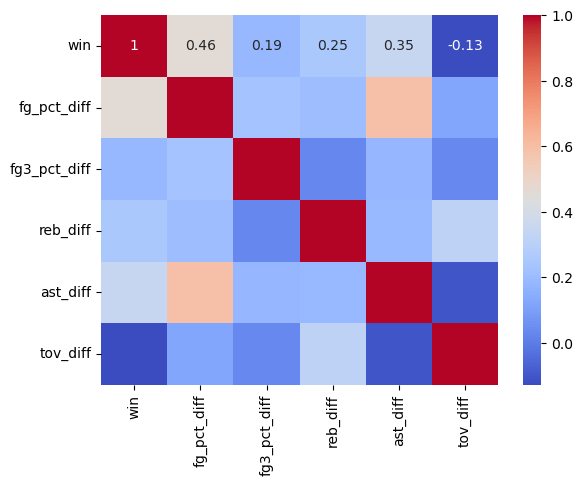

In [6]:
import seaborn as sns
correlation_matrix = data[['win', 'fg_pct_diff', 'fg3_pct_diff', 'reb_diff', 'ast_diff', 'tov_diff']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [7]:
X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

len(X)

38902

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler

class_distribution = data['win'].value_counts()
print(class_distribution)
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)
X,y = X_resampled, y_resampled 

win
1    24877
0    14025
Name: count, dtype: int64


In [9]:
unique, frequency = np.unique(y, 
                              return_counts = True)
# print unique values array
print("Unique Values:", 
      unique)
 
# print frequency array
print("Frequency Values:",
      frequency)

Unique Values: [0 1]
Frequency Values: [24877 24877]


In [10]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 5)
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
cm

array([[3585, 2678],
       [ 590, 5586]])

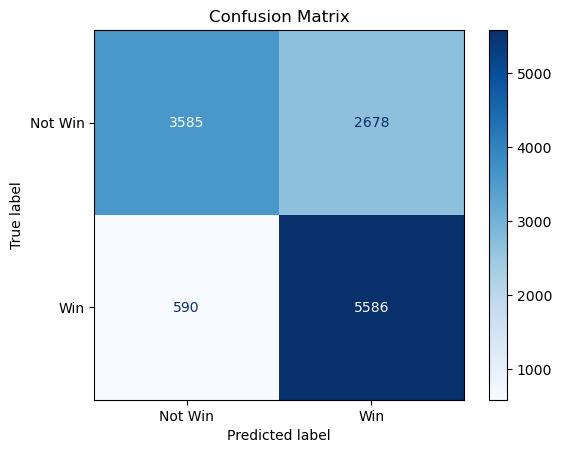

In [11]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Win', 'Win'])
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [12]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score
accuracy = accuracy_score(y_test,y_pred)


In [13]:
accuracy

0.7372779162312083

In [14]:
precision = 3544/(3544+418)

In [15]:
precision

0.8944977284199899

In [16]:
y_pred_prob = lr.predict_proba(X_test)[:, 1] 

In [17]:
from sklearn.metrics import roc_auc_score

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'ROC-AUC: {roc_auc:.2f}')

ROC-AUC: 0.84


In [24]:
import pickle

# Save the model to a file
with open('lr_bef_2003.pkl', 'wb') as file:
    pickle.dump(lr, file)

### Ensemble model

In [18]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()

In [19]:
gb.fit(X_train,y_train)

GradientBoostingClassifier()

In [20]:
cm1 = confusion_matrix(y_test,gb.predict(X_test))

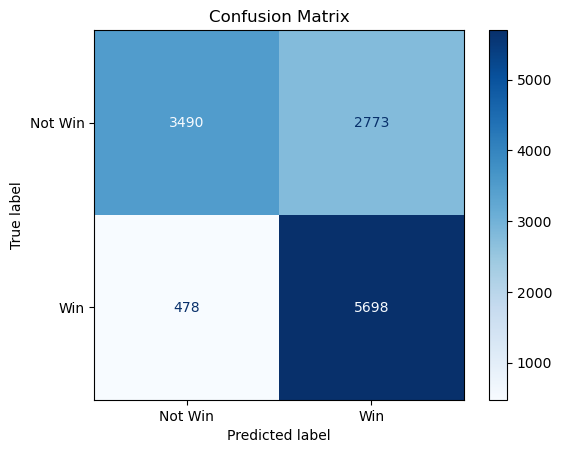

In [21]:
cm_display1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=['Not Win', 'Win'])
cm_display1.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [22]:
accuracy1 = accuracy_score(y_test,gb.predict(X_test))
accuracy1

0.7386445855776188